In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold
import warnings
from tqdm import tqdm_notebook
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train=pd.read_csv('../input/tabular-playground-series-jun-2021/train.csv')
test=pd.read_csv('../input/tabular-playground-series-jun-2021/test.csv')
subm=pd.read_csv('../input/tabular-playground-series-jun-2021/sample_submission.csv')

train.drop('id',axis=1,inplace=True)


In [3]:
print('Number of train samples %d'%train.shape[0])
print('Number of train fetures %d'%train.shape[1])
print('Number of test samples %d'%test.shape[0])
print('Number of test fetures %d'%test.shape[1])

Number of train samples 200000
Number of train fetures 76
Number of test samples 100000
Number of test fetures 76


In [4]:
train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
0,0,0,6,1,0,0,0,0,7,0,...,0,0,0,0,0,0,2,0,0,Class_6
1,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,1,0,Class_6
2,0,0,0,0,0,1,0,3,0,0,...,0,0,0,0,1,0,0,0,0,Class_2
3,0,0,7,0,1,5,2,2,0,1,...,0,4,0,2,2,0,4,3,0,Class_8
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_2


# Target Distribution

<AxesSubplot:>

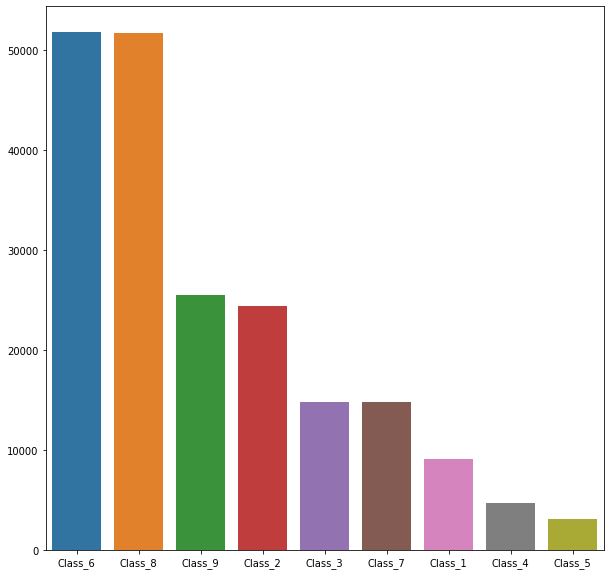

In [5]:
target_values = train['target'].value_counts().to_frame().T
plt.figure(figsize = (10,10))
sns.barplot(x = target_values.columns,y = target_values.values.reshape(-1,))

# Unique Counts for Features

let's look at the number of values for each feature to check whether there are any ordinal/categorical features

<AxesSubplot:>

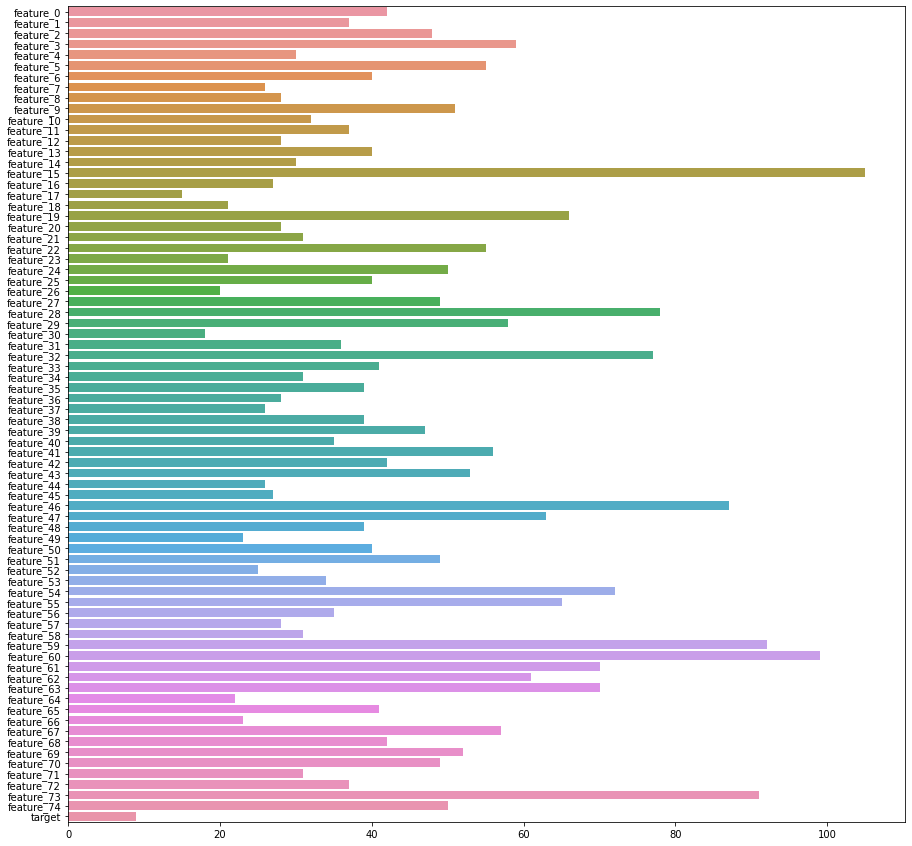

In [6]:
features_count_df = train.nunique(axis=0).to_frame()
features_count_df = features_count_df.T
plt.figure(figsize = (15,15))
sns.barplot(y = features_count_df.columns,x = features_count_df.values.reshape(-1,))

# Correlation HeatMap

<AxesSubplot:>

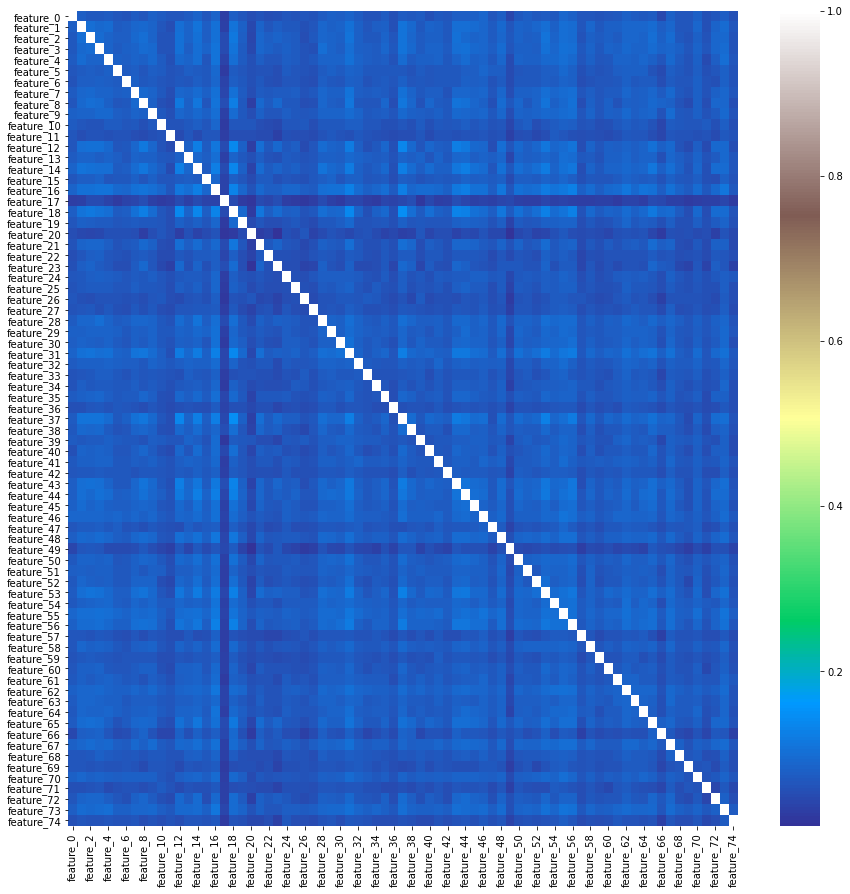

In [7]:
plt.figure(figsize = (15,15))
sns.heatmap(train.corr(),cmap = 'terrain')

In [8]:
sorted(np.unique(train.corr().values.ravel()))[-2]

0.1444350022687877

Therefore,no two pair of features are significantly correlated

# Skewness Barplot

<AxesSubplot:>

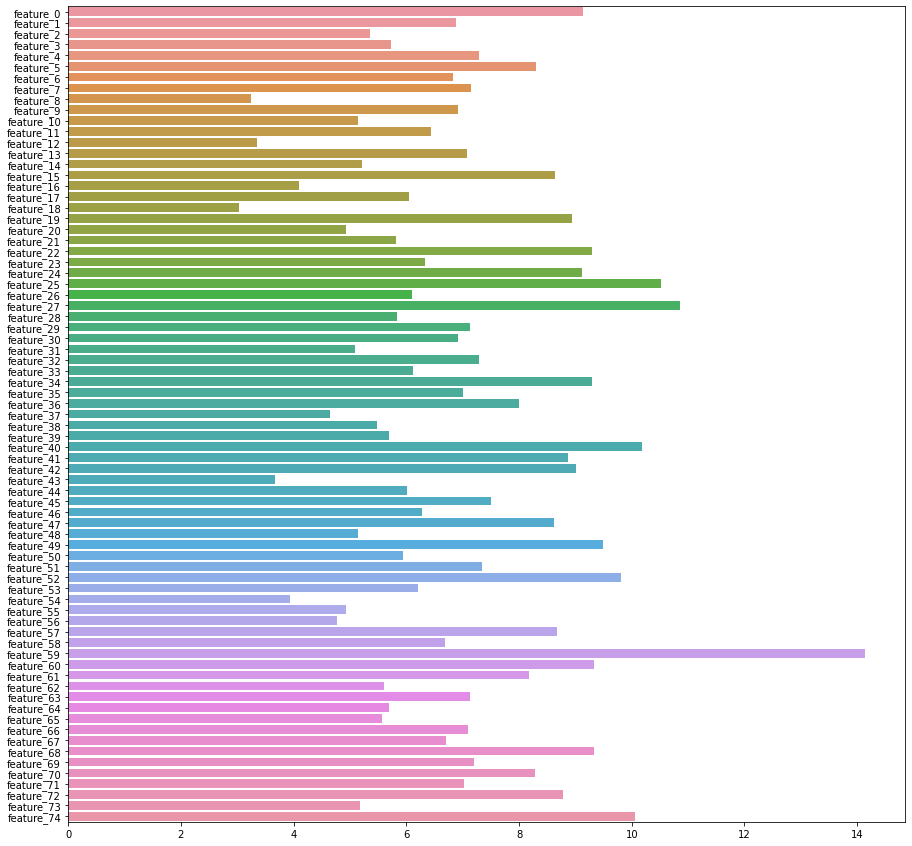

In [9]:
skewness_data = train.skew(axis=0).to_frame().T
plt.figure(figsize = (15,15))
sns.barplot(y = skewness_data.columns,x = skewness_data.values.reshape(-1,))

Seems quite a few number of features are significantly skewed, let's look at the distribution of a couple of them

<AxesSubplot:xlabel='feature_59', ylabel='Density'>

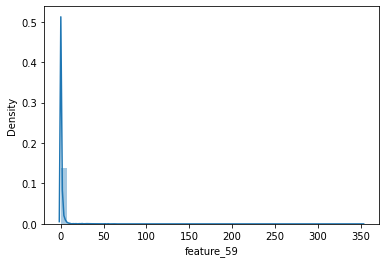

In [10]:
sns.distplot(train['feature_59'])

<AxesSubplot:xlabel='feature_27', ylabel='Density'>

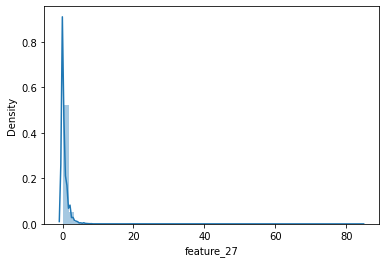

In [11]:
sns.distplot(train['feature_27'])

# Detecting MultiCollinearity

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
train_x=train.iloc[:,:-1]
vif_data = pd.DataFrame()
vif_data["feature"] = train_x.columns
vif_data["VIF"] = [variance_inflation_factor(train_x.values, i) for i in tqdm_notebook(range(len(train_x.columns)))]
  

  0%|          | 0/75 [00:00<?, ?it/s]

In [13]:

vif_data['VIF'].describe()

count    75.000000
mean      1.199423
std       0.104658
min       1.068760
25%       1.127719
50%       1.168950
75%       1.227805
max       1.584544
Name: VIF, dtype: float64

All vifs are far less than 4. Suggests absence of strong multicollinearlity

In [14]:
n_folds=5
from xgboost import XGBClassifier
skf = StratifiedKFold(n_splits=n_folds)
from sklearn.metrics import accuracy_score
import pickle
train['fold']=-1
target=train.target
for i,(train_idx,val_idx) in enumerate(skf.split(train,target)):
    train.loc[val_idx,'fold']=i

<AxesSubplot:>

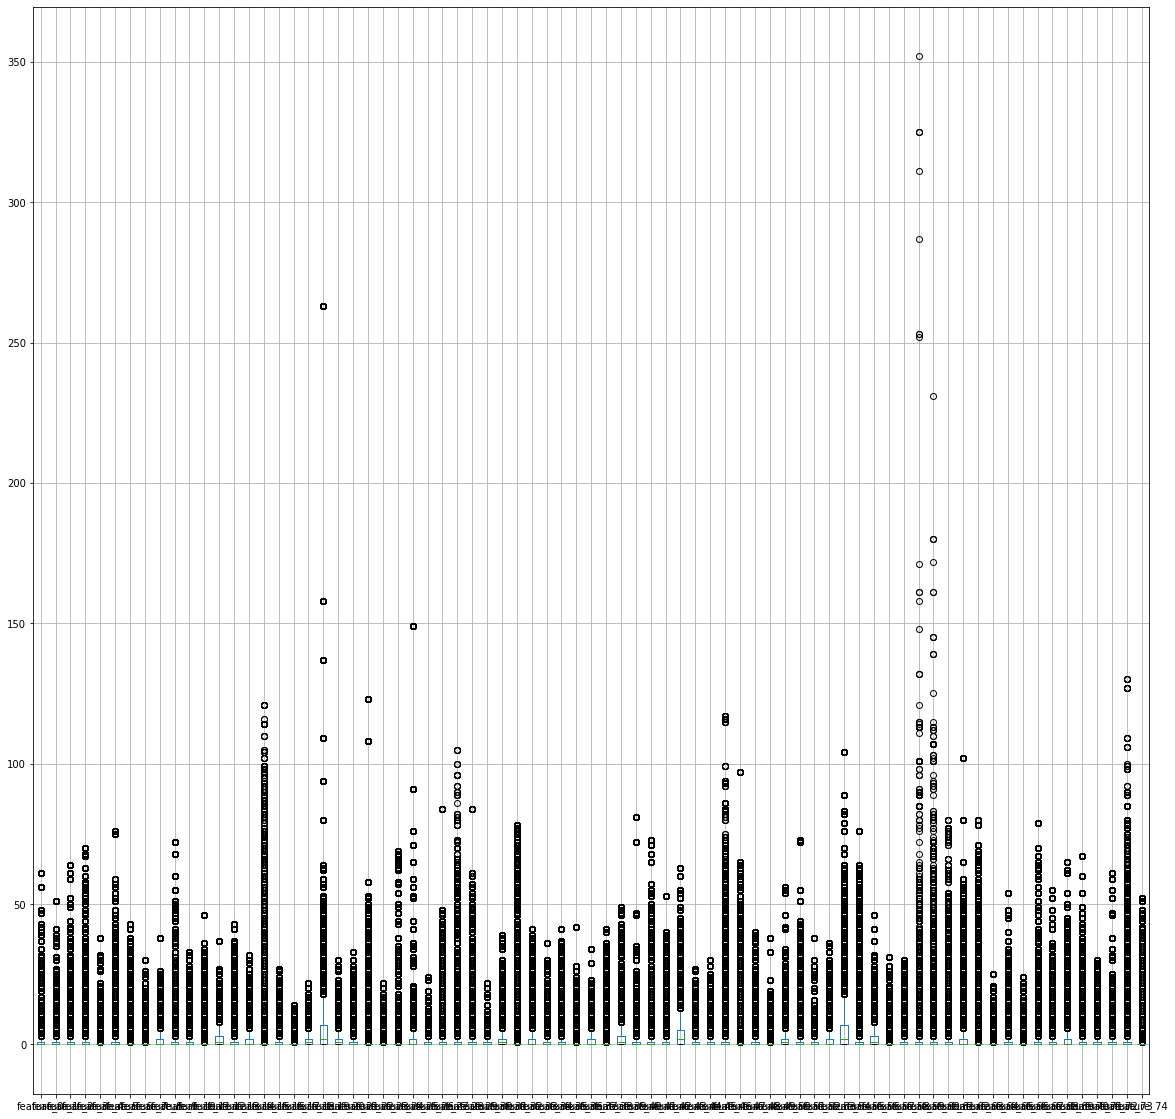

In [15]:
train.boxplot(column=list(train.drop(['target','fold'],axis=1).columns),figsize=(20,20))

<AxesSubplot:>

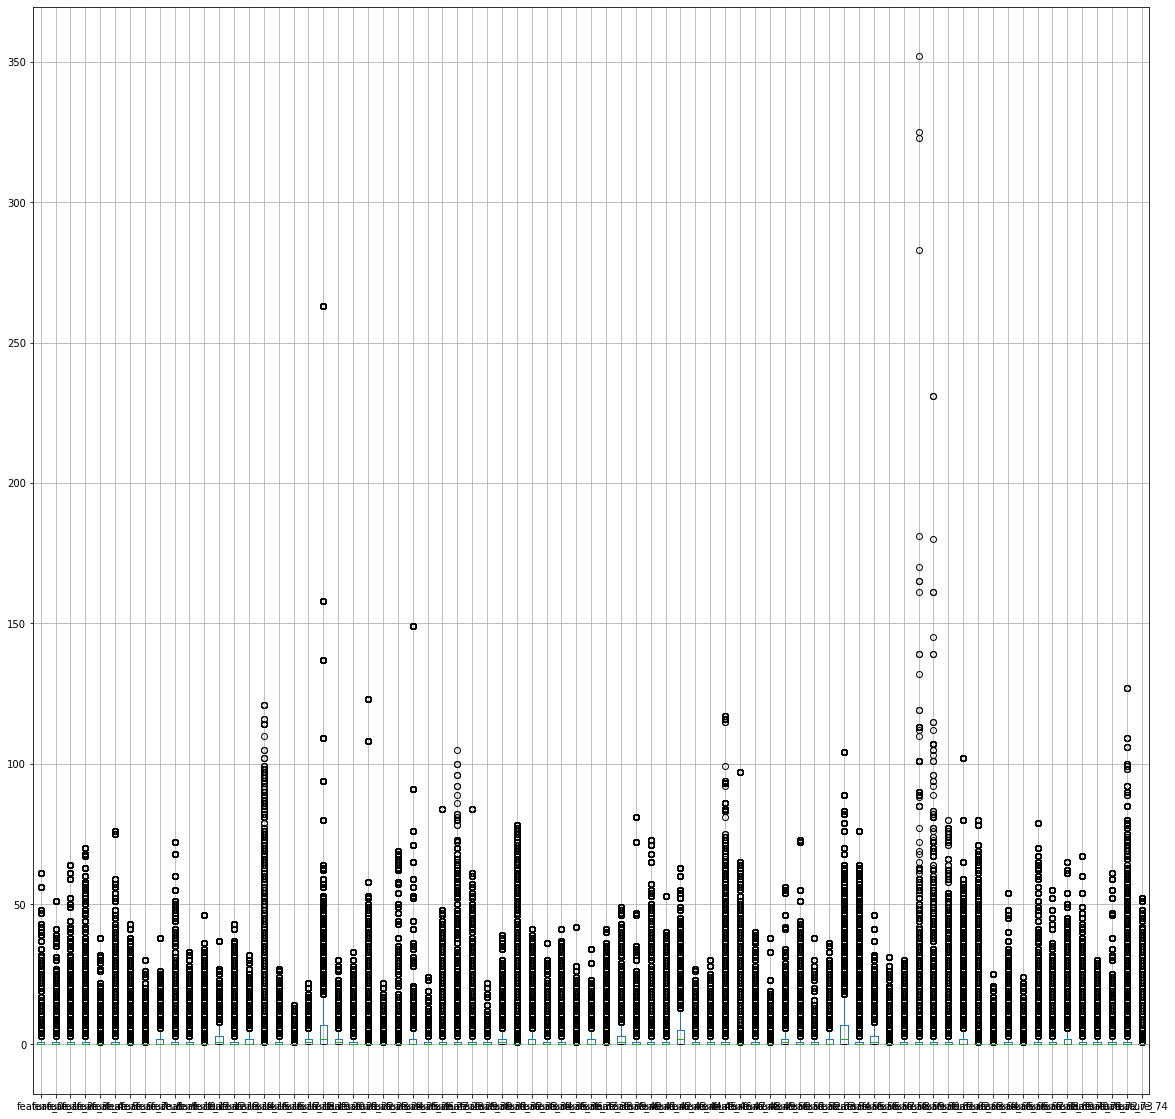

In [16]:
test.boxplot(column=list(test.drop('id',axis=1).columns),figsize=(20,20))

In [17]:
train['feature_0'].nunique(),test['feature_0'].nunique()

(42, 42)

In [18]:
from sklearn.ensemble import IsolationForest
def eliminate_outliers(x_train,y_train,cont=0.1):
    iso = IsolationForest(contamination=cont)
    yhat = iso.fit_predict(x_train)
    mask = yhat != -1
    X_train, Y_train = x_train.iloc[mask, :], y_train[mask]
    return X_train,Y_train
    

In [19]:

acc_scores=[]
for fold in tqdm_notebook(range(n_folds)):
    print(f'----Fold {fold}----')
    x_val, y_val = train[train['fold'] == fold].drop(['target','fold'],axis=1), train[train['fold'] == fold].target
    x_train ,y_train = train[train['fold'] != fold].drop(['target','fold'],axis=1), train[train['fold'] != fold].target
    
    x_train,y_train=eliminate_outliers(x_train,y_train,cont=0.01)
    model = XGBClassifier(n_estimators=1000,learning_rate=0.1)
    model.fit(x_train, y_train , eval_set=[(x_val, y_val)], early_stopping_rounds=5, verbose=False)
    y_pred = model.predict(x_val)
    acc = accuracy_score(y_val, y_pred)
    acc_scores.append(acc)
    pickle.dump(model, open(f"model{fold}.pickle.dat", "wb"))
    print(f"Fold={fold},Accuracy={acc}")
    del model
    
    
    
    

  0%|          | 0/5 [00:00<?, ?it/s]

----Fold 0----
[03:29:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold=0,Accuracy=0.3596
----Fold 1----
[03:32:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold=1,Accuracy=0.36185
----Fold 2----
[03:36:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold=2,Accuracy=0.362225
----Fold 3----
[03:39:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used wit

In [20]:
mean_val_accuracy=np.mean(acc_scores)
print("Mean validation accuracy %f"%mean_val_accuracy)

Mean validation accuracy 0.360525


In [21]:
submission_df=pd.DataFrame(columns=['id','class_1','class_2','class_3','class_4','class_5','class_6','class_7','class_8','class_9'])
probs=0
for fold in range(n_folds):
    loaded_model = pickle.load(open(f"model{fold}.pickle.dat", "rb"))
    probs+=loaded_model.predict_proba(test.drop('id',axis=1))
submission_df['id']=test.id.values
submission_df[['class_1','class_2','class_3','class_4','class_5','class_6','class_7','class_8','class_9']]=probs/n_folds

    

In [22]:
submission_df.to_csv('submission.csv',index=None)